<a href="https://colab.research.google.com/github/Usually-zz/2021_IMC/blob/main/gmm_em_expressions_cell_sizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
def _e_step(X, S, pi_d0, pi_c, pi_cc, emu_c, eco_c, smu_c, sco_c):

  n, p = X.shape
  c = pi_cc.shape[0]

  log_pi_d0 = torch.log(torch.tensor(pi_d0))
  log_pi_d1 = torch.log(torch.tensor(1 - pi_d0))
  
  log_pi_c = torch.log(pi_c)
  log_pi_cc = torch.log(pi_cc)

  ### E-step:
  log_post_top0 = torch.zeros(c, n)
  log_post_top1 = torch.zeros(c, c, n)

  for j in range(c):
  
    el0 = torch.distributions.MultivariateNormal(emu_c[j].float(), eco_c[j].float()).log_prob(X.float())
    sl0 = torch.distributions.Normal(smu_c[j].float(), sco_c[j].float()).log_prob(S.float())
    log_post_top0[j] = log_pi_d0 + log_pi_c[j] + el0 + sl0

    for k in range(c):
      el1 = torch.distributions.MultivariateNormal((emu_c[j] + emu_c[k]).float()/2, (eco_c[j] + eco_c[k]).float()/2).log_prob(X.float())
      #https://stats.stackexchange.com/questions/99363/mean-of-covariance-matrices
      #https://stats.stackexchange.com/questions/214174/calculating-the-covariance-matrix-for-the-mean-of-variables
      sl1 = torch.distributions.Normal((smu_c[j] + smu_c[k]).float(), (sco_c[j] + sco_c[k]).float()).log_prob(S.float())

      if torch.isnan(pi_cc[j,k]): #lower triangular nan
        log_post_top1[j,k] = float("-Inf")
      else:
        log_post_top1[j,k] = log_pi_d1 + log_pi_cc[j,k] + el1 + sl1

  log_post_bot0 = torch.logsumexp(log_post_top0, 0) #n
  log_post_z = (log_post_top0 - log_post_bot0).T #nxc (rjk)
  #log_post_z[torch.isnan(log_post_z)] = 0

  log_post_top1 = log_post_top1.reshape(c * c, n) #reshape
  log_post_bot1 = torch.logsumexp(log_post_top1, 0) #n
  log_post_g = (log_post_top1 - log_post_bot1).T #nxc (rijk)
  log_post_g[torch.isnan(log_post_g)] = 0

  bot = torch.exp(log_post_bot0) + torch.exp(log_post_bot1) #+ 1e-6
  tlls = torch.mean(torch.log(bot))

  log_post_d0 = log_post_bot0 - torch.log(bot)
  log_post_d1 = log_post_bot1 - torch.log(bot)

  #print( torch.mean((torch.exp(log_post_bot1) + torch.exp(log_post_bot0))/ bot) )
  #print(torch.sum(torch.exp(log_post_d0)) + torch.sum(torch.exp(log_post_d1)))
  #print(torch.mean(torch.exp(post_d0)))
  #print(torch.mean(torch.exp(post_d1)))

  log_post_dz = log_post_d0[:,None] + log_post_z
  log_post_dg = log_post_d1[:,None] + log_post_g

  return tlls, log_post_d0, log_post_d1, log_post_z, log_post_g, log_post_dz, log_post_dg

def _estimate_mean_cov_t1v2(X, S, r_ij, reg=1e-6):

  n, p = X.shape
  n, c = r_ij.shape

  smut = torch.zeros(c)
  scot = torch.zeros(c)

  emut = torch.zeros(c, p)
  ecot = torch.zeros(c, p, p)

  n_c = torch.sum(r_ij, dim=0) + reg # (c)

  for j in range(c):
    e_n = torch.round(n_c[j])
    idx = r_ij[:,j].argsort()[-e_n.int():]
    smut[j] = torch.mean(S[idx], 0)
    emut[j] = torch.mean(X[idx], 0)
    if e_n > 1:
      ecot[j] = torch.tensor(np.cov(X[idx].T, ddof=0)) + reg * torch.eye(p)
      scot[j] = torch.std(S[idx]) + reg
    else:
      ecot[j] = reg * torch.eye(p)
      scot[j] = reg
  return n_c, smut, scot, emut, ecot


def _estimate_mean_cov_t2v2(X, S, r_ijk, reg=1e-6):

  n, p = X.shape
  n, c, c = r_ijk.shape

  smut = torch.zeros(c, c)
  scot = torch.zeros(c, c)

  emut = torch.zeros(c, c, p)
  ecot = torch.zeros(c, c, p, p)

  n_cc = torch.sum(r_ijk, dim=0) + reg # (cxc)

  for j in range(c):
    for k in range(c):
      if not torch.isnan(n_cc[j,k]):
        e_n = torch.round(n_cc[j,k])
        idx = r_ijk[:,j,k].argsort()[-e_n.int():]
        smut[j,k] = torch.mean(S[idx], 0)
        emut[j,k] = torch.mean(X[idx], 0)
        if e_n > 1:
          scot[j,k] = torch.std(S[idx]) + reg
          ecot[j,k] = torch.tensor(np.cov(X[idx].T, ddof=0)) + reg * torch.eye(p)
        else:
          scot[j,k] = reg
          ecot[j,k] = reg * torch.eye(p)
  return n_cc, smut, scot, emut, ecot

def _m_step(X, S, log_postd0, log_postd1, log_postdz, log_postdg, reg=1e-6):

  n_obs, n_comp = log_postdz.shape
  n_obs, n_feat = X.shape

  #r_i = torch.exp(log_postd0) 
  #pi_d1 = torch.sum(torch.exp(log_postd1)) / n_obs # one value
  pi_d0 = torch.sum(torch.exp(log_postd0)) / n_obs # one value

  r_ij = torch.exp(log_postdz)
  n_c, smu_c, sco_c, emu_c, eco_c = _estimate_mean_cov_t1v2(X, S, r_ij)
  pi_c = n_c / n_obs # c values

  indx = []
  for j in range(log_postdg.shape[1]):
    if torch.sum(torch.isinf(log_postdg[:,j])) == log_postdg.shape[0]:
      indx.append(j)
  log_postdg[:,indx] = float('NaN')

  r_ijk = torch.exp(log_postdg).reshape(n_obs, n_comp, n_comp)
  n_cc, smu_cc, sco_cc, emu_cc, eco_cc = _estimate_mean_cov_t2v2(X, S, r_ijk)
  pi_cc = n_cc / n_obs  # cxc matrix  

  return pi_d0, n_c, pi_c, emu_c, eco_c, smu_c, sco_c, n_cc, pi_cc, emu_cc, eco_cc, smu_cc, sco_cc

In [42]:
n_clusters = 3
n_features = 2

## ground true expressions ##
true_expression_means = torch.tensor([
    [1, 2],
    [4, 3],
    [7, 9]
])

true_expression_covs = torch.tensor([
    [[.1, 0], [0, .1]],
    [[.3, 0], [0, .3]],
    [[.2, 0], [0, .2]]
])

In [43]:
## ground true cell size ##

#true_size_means = torch.rand(n_clusters)
#true_size_means = torch.sort(torch.rand(n_clusters))[0]
#true_size_means = torch.sort(torch.randint(0, 10, (3,)))[0]
true_size_means = torch.tensor([.4, .5, .6])

print(true_size_means)

true_size_stds = torch.tensor([.1, .05, .01])
true_size_stds

tensor([0.4000, 0.5000, 0.6000])


tensor([0.1000, 0.0500, 0.0100])

In [44]:
## other ground true for generating data ##
d_ws = torch.tensor([.95, .05])
z_ws = torch.tensor([1 / 4, 1 / 2, 1 / 4])
g_ws = torch.tensor([0.0667, 0.1333, 0.2000, 0.1000, 0.2667, 0.2333])

N = 5000
gs = np.sum(np.random.choice(len(d_ws), size = N, p = d_ws))
zs = N - gs

In [45]:
## simulate data
x = np.zeros((zs, n_features+4))
for i in range(zs):
  z = np.random.choice(n_clusters, size = 1, p = z_ws)[0]
  x[i] = np.append(np.random.multivariate_normal(true_expression_means[z], true_expression_covs[z]), [np.random.normal(true_size_means[z], true_size_stds[z]), 0, z, z+6])
  
xxx = np.zeros((gs, n_features+4))

for i in range(gs):

  g = np.random.choice(6, size = 1, p = g_ws)[0]
    
  if g == 0:
    idx = [0,0]
  elif g == 1:
    idx = [0,1]
  elif g == 2:
    idx = [0,2]
  elif g == 3:
    idx = [1,1]
  elif g == 4:
    idx = [1,2]
  else:
    idx = [2,2]

  #es1 = x[(x[:,3] == 0) & (x[:,4] == idx[0])]
  #es2 = x[(x[:,3] == 0) & (x[:,4] == idx[1])]
  #xxx[i] = np.append((es1[np.random.choice(es1.shape[0], size = 1)[0],:2] + es2[np.random.choice(es2.shape[0], size = 1)[0],:2])/2, 
  #                   [es1[np.random.choice(es1.shape[0], size = 1)[0],2] + es2[np.random.choice(es2.shape[0], size = 1)[0],2], 1, g, g])
  
  xxx[i] = np.append(np.random.multivariate_normal( (true_expression_means[idx[0]] + true_expression_means[idx[1]])/2, (true_expression_covs[idx[0]] + true_expression_covs[idx[1]])/2 ),
                     [np.random.normal( (true_size_means[idx[0]] + true_size_means[idx[1]]), (true_size_stds[idx[0]] + true_size_stds[idx[1]]) ), 1, g, g])
  
xx = np.append(x, xxx).reshape(N,6)

X = torch.tensor(xx[:,:2])
S = torch.tensor(xx[:,2])

In [7]:
#sns.pairplot(pd.DataFrame(xx[:,:3]))

In [46]:
import plotly.express as px
tt = pd.DataFrame(xx)
tt.columns = ['x', 'y', 's', 'd', 'c', 'l']
tt = tt.astype({"l":'category'})
tt.info()
fig = px.scatter_3d(tt, x='x', y='y', z='s', color='l')
fig.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   x       5000 non-null   float64 
 1   y       5000 non-null   float64 
 2   s       5000 non-null   float64 
 3   d       5000 non-null   float64 
 4   c       5000 non-null   float64 
 5   l       5000 non-null   category
dtypes: category(1), float64(5)
memory usage: 200.7 KB


In [47]:
## initializations ##

emu_c = torch.tensor([
    [3, 1], # 1 2
    [5, 4], # 4 3
    [6, 8] # 7 9
])

eco_c = torch.tensor([
    [[.1, 0], [0, .1]],
    [[.1, 0], [0, .1]],
    [[.1, 0], [0, .1]]
])

smu_c = torch.tensor([.4, .5, .6])
sco_c = torch.tensor([0.1, 0.1, 0.1])

pi_d0 = 0.9

pi_c = torch.empty(n_clusters).fill_(1. / n_clusters)

pi_cc = torch.triu(torch.ones(n_clusters, n_clusters))
pi_cc = pi_cc / torch.sum(pi_cc)
pi_cc[pi_cc == 0] = float('NaN')

In [48]:
## training ##

itermax = 50
tot = 1e-10

iter = 0
llv = [0.0]
while iter < itermax:
  
  lli, log_pd0, log_pd1, log_pz, log_pg, log_dz, log_dg = _e_step(X, S, pi_d0, pi_c, pi_cc, emu_c, eco_c, smu_c, sco_c)
  pi_d0, n_c, pi_c, emu_c, eco_c, smu_c, sco_c, n_cc, pi_cc, emu_cc, eco_cc, smu_cc, sco_cc = _m_step(X, S, log_pd0, log_pd1, log_dz, log_dg)
  
  print('Iteration', iter + 1, 'Likelihood: ', lli)

  if abs(llv[-1] - lli) < tot:
    break
      
  llv.append(lli)
  iter += 1

  #return llv[1:]

Iteration 1 Likelihood:  tensor(-12.3150)
Iteration 2 Likelihood:  tensor(-2.3244)
Iteration 3 Likelihood:  tensor(-1.1359)
Iteration 4 Likelihood:  tensor(-0.9160)
Iteration 5 Likelihood:  tensor(-0.9110)
Iteration 6 Likelihood:  tensor(-0.9109)
Iteration 7 Likelihood:  tensor(-0.9109)
Iteration 8 Likelihood:  tensor(-0.9109)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



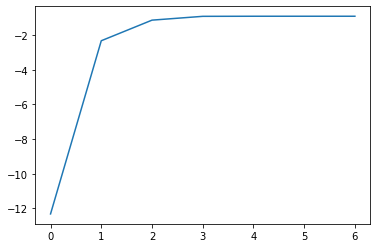

In [49]:
plt.plot(llv[1:])

In [50]:
pi_d0

tensor(0.9564)

In [51]:
n_c

tensor([1157.4379, 2428.4629, 1196.0000])

In [52]:
n_cc

tensor([[ 9.2773, 27.5654, 37.4201],
        [    nan, 32.8605, 49.6744],
        [    nan,     nan, 61.3019]])

In [53]:
torch.sum(n_c) + torch.sum(torch.triu(n_cc))

tensor(5000.0005)

In [54]:
emu_c

tensor([[0.9901, 1.9911],
        [4.0028, 3.0252],
        [6.9868, 8.9992]])

In [55]:
true_expression_means

tensor([[1, 2],
        [4, 3],
        [7, 9]])

In [56]:
smu_c

tensor([0.3974, 0.4986, 0.5998])

In [57]:
true_size_means

tensor([0.4000, 0.5000, 0.6000])

In [58]:
pi_cc

tensor([[0.0019, 0.0055, 0.0075],
        [   nan, 0.0066, 0.0099],
        [   nan,    nan, 0.0123]])

In [59]:
pi_c

tensor([0.2315, 0.4857, 0.2392])

In [60]:
## check number of points in each cluster
for i in range(9):
  print(sum(xx[:,5] == i)/N)

0.0036
0.006
0.0076
0.0066
0.01
0.0122
0.2294
0.4854
0.2392


In [61]:
eco_c

tensor([[[ 1.0391e-01,  1.9599e-04],
         [ 1.9599e-04,  1.0104e-01]],

        [[ 2.9696e-01,  4.5659e-03],
         [ 4.5659e-03,  2.9596e-01]],

        [[ 1.9911e-01, -6.9324e-03],
         [-6.9324e-03,  2.0961e-01]]])

In [62]:
true_expression_covs

tensor([[[0.1000, 0.0000],
         [0.0000, 0.1000]],

        [[0.3000, 0.0000],
         [0.0000, 0.3000]],

        [[0.2000, 0.0000],
         [0.0000, 0.2000]]])

In [63]:
sco_c

tensor([0.1039, 0.0505, 0.0099])

In [64]:
true_size_stds

tensor([0.1000, 0.0500, 0.0100])

In [ ]:
## make predictions ##s
pp = torch.zeros((N, 7))

dd = torch.exp(log_pd0)
zd = torch.exp(log_dz)
gd = torch.exp(log_dg)

for i in range(N):
  if dd[i] > .5:
    pp[i] = torch.hstack( (torch.tensor(xx[i]), torch.tensor(torch.max(zd[i], 0).indices)+6) )
  else:
    pp[i] = torch.hstack( (torch.tensor(xx[i]), torch.tensor(torch.max(gd[i][~torch.isnan(gd[i])], 0).indices)) )

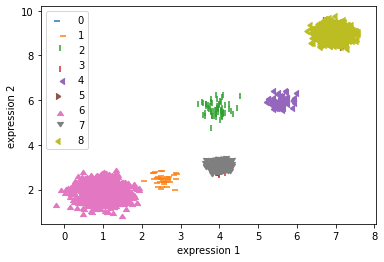

In [28]:
for i in range(9):
    plt.scatter(pp[pp[:,5] == i , 0] , pp[pp[:,5] == i , 1] , label = i, marker=i)
plt.legend()
plt.xlabel("expression 1")
plt.ylabel("expression 2")
plt.show()

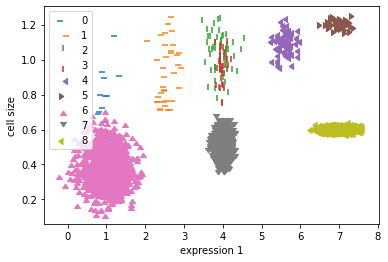

In [29]:
for i in range(9):
  plt.scatter(pp[pp[:,5] == i , 0] , pp[pp[:,5] == i , 2] , label = i, marker=i)
plt.legend()
plt.xlabel("expression 1")
plt.ylabel("cell size")
plt.show()

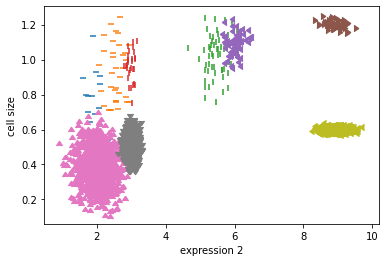

In [30]:
for i in range(9):
  plt.scatter(pp[pp[:,5] == i , 1] , pp[pp[:,5] == i , 2] , label = i, marker=i)
plt.xlabel("expression 2")
plt.ylabel("cell size")
plt.show()

In [66]:
preds = pd.DataFrame(np.array(pp))
#preds.info()
preds.columns = ['x', 'y', 's', 'd', 'c', 'truth', 'pred']
preds['dn0'] = torch.exp(log_pd0)
preds['dn1'] = torch.exp(log_pd1)

In [67]:
preds[preds.truth != preds.pred].pred.value_counts()

6.0    10
7.0     3
3.0     2
4.0     2
1.0     2
0.0     1
2.0     1
Name: pred, dtype: int64

In [33]:
#hhh = torch.tensor(np.array(preds[preds.truth != preds.pred]))
#hhh = torch.tensor(xx[torch.exp(log_pd0) + torch.exp(log_pd1) < .9])

In [ ]:
'''
ttt0 = torch.zeros(3, hhh.shape[0])
ttt1 = torch.zeros(3, 3, hhh.shape[0])

for j in range(3):

  tel0 = torch.distributions.MultivariateNormal(emu_c[j].float(), eco_c[j].float()).log_prob(hhh[:,:2].float())
  tsl0 = torch.distributions.Normal(smu_c[j].float(), sco_c[j].float()).log_prob(hhh[:,2].float())
  ttt0[j] = torch.log(pi_d0) + torch.log(pi_c[j]) + tel0 + tsl0

  for k in range(3):
    tel1 = torch.distributions.MultivariateNormal((emu_c[j] + emu_c[k]).float()/2, (eco_c[j] + eco_c[k]).float()/2).log_prob(hhh[:,:2].float())
    tsl1 = torch.distributions.Normal((smu_c[j] + smu_c[k]).float(), (sco_c[j] + sco_c[k]).float()).log_prob(hhh[:,2].float())

    if ~torch.isnan(pi_cc[j,k]):
      ttt1[j,k] = torch.log(1 - pi_d0) + torch.log(pi_cc[j,k]) + tel1 + tsl1
    else:
      ttt1[j,k] = float("-Inf")

ttop1 = ttt1.reshape(9, hhh.shape[0])
tbot1 = torch.logsumexp(ttop1, 0) #n

tbot0 = torch.logsumexp(ttt0, 0) #n
#log_post_z[torch.isnan(log_post_z)] = 0

bt = torch.vstack((ttop1, ttt0))
bb = torch.logsumexp(bt, 0)

i = 7
print(torch.exp((ttt0 - tbot0).T)[i])
print(torch.exp((ttop1 - tbot1).T)[i])

#print(torch.argmax(torch.exp((bt - bb).T)[i]))
torch.exp((bt - bb).T)[i]
'''

In [ ]:
'''
0 [1.05410194 2.06649774 0.7606945 ]
1 [2.48516375 2.49897271 0.91841523]
2 [3.97791461 5.4692703  0.98465884]
3 [4.01594298 3.03114797 0.97797493]
4 [5.4629664  5.97913948 1.10426473]
5 [7.0161063  8.97092334 1.19930124]
6 [1.00317153 1.99675189 0.40179555]
7 [3.99861931 2.99746574 0.50047   ]
8 [7.0050963  8.99494863 0.59900982]
'''

In [68]:
## check expression means from the generated data
for i in range(9):
  print(np.mean(xx[xx[:,5] == i,:3], 0))

[0.93897359 2.03065985 0.81720225]
[2.50208899 2.46655692 0.93683985]
[4.05223124 5.35552657 0.98863694]
[4.06638962 3.06198837 0.97791302]
[5.48276874 6.07097786 1.10081361]
[6.96362982 9.04557182 1.20350564]
[0.98875914 1.99029117 0.39537799]
[4.00249889 3.0249301  0.49841224]
[6.98679327 8.99919603 0.59978755]


In [ ]:
#preds[preds.truth != preds.pred]

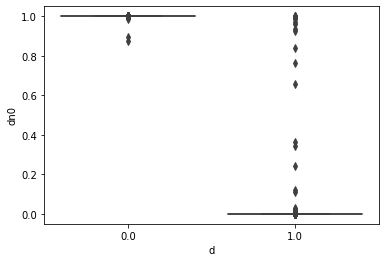

In [69]:
ax = sns.boxplot(x="d", y='dn0', data=preds)
plt.show()

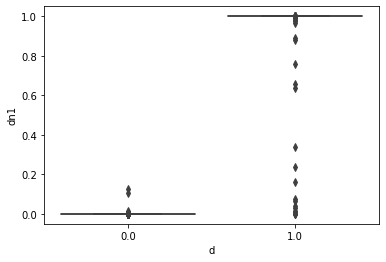

In [70]:
ax = sns.boxplot(x="d", y='dn1', data=preds)
plt.show()

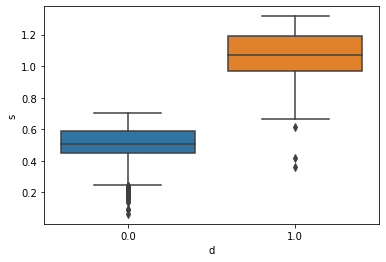

In [71]:
ax = sns.boxplot(x="d", y="s", data=preds)
plt.show()

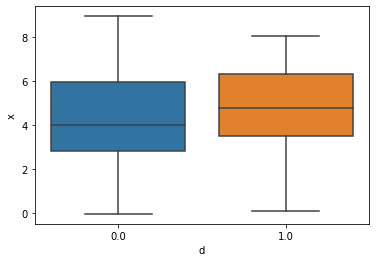

In [72]:
ax = sns.boxplot(x="d", y="x", data=preds)
plt.show()

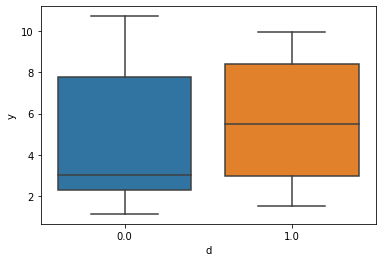

In [73]:
ax = sns.boxplot(x="d", y="y", data=preds)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(pp[:,0]), np.array(pp[:,1]), np.array(pp[:,2]), marker="s", c = preds["pred"])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(pp[:,0]), np.array(pp[:,1]), np.array(pp[:,2]), marker="s", c = preds["truth"])

In [ ]:
fig = px.scatter_3d(preds, x='x', y='y', z='s', color='pred')
fig.show()

In [ ]:
fig = px.scatter_3d(preds, x='x', y='y', z='s', color='truth')
fig.show()

In [41]:
sum(pp[:,6] == pp[:,5]) / N

tensor(0.9984)

In [ ]:
'''
from google.colab import drive
drive.mount("/content/gdrive")
%pwd
%cd /content/gdrive/MyDrive/Colab\ Notebooks
'''

In [ ]:
#!pip install scanpy
#import scanpy as sc

In [ ]:
#s1 = sc.read_h5ad("single_cell_expression_s1.h5ad")
#s2 = sc.read_h5ad("single_cell_expression_s2.h5ad")
#s3 = sc.read_h5ad("single_cell_expression_s3.h5ad")

In [ ]:
#s3.obs_names_make_unique

In [ ]:
#ax = sns.boxplot(x="size", data=s3.obs)
# show plot
#plt.show()

In [ ]:
#s3.obs[['size']].value_counts()

In [ ]:
'''
for i in range(39):
  fig, ax = plt.subplots()
  scatter = ax.scatter(s3.X[:,i], np.array(s3.obs[['size']]), c = np.array(s3.obs[['size']]))
  ax.add_artist(ax.legend(*scatter.legend_elements(), title= "Size"))
  plt.show()
'''

In [ ]:
#s3.var_names

In [ ]:
#len(s3.var_names)

In [ ]:
#import scanpy as sc
#sc.pl.umap(s3, color = s3.var_names)

In [ ]:
#sc.pl.dotplot(s3, groupby='size', var_names=s3.var_names)

In [ ]:
#sc.pl.dotplot(s3, groupby='leiden', var_names=s3.var_names)